# Cost Analysis

In [ ]:
import json
import glob


data_path = f'datasets_same_topic/*_qaset.jsonl'
data_files = glob.glob(data_path)

model_cost = {}
model_error = {}
for data_f in data_files:
    with open(data_f, 'r') as f:
        model_name = data_f.split('/')[-1].split('_')[0]
        data = [json.loads(l) for l in f.readlines()][-20000:]
        corr = sum([d['label'] for d in data])
        cost = sum([d['cost'] for d in data])
        input_tokens = sum([d['input_tokens'] for d in data])
        output_tokens = sum([d['output_tokens'] for d in data])
    model_cost[model_name] = cost
    model_error[model_name] = (len(data), len(data) - corr)

In [19]:
import json
import glob


data_path = f'res_same_topic/*/cost_list.txt'
data_files = glob.glob(data_path)

for data_f in data_files:
    with open(data_f, 'r') as f:
        model_name = data_f.split('/')[-2].split('_')[0]
        cost_list = json.loads(f.read())
    if isinstance(cost_list[0], float):
        total_cost = sum(cost_list[-20:])
        gen_cost = total_cost - model_cost[model_name]
        inf_cost = model_cost[model_name]
    if isinstance(cost_list[0], list):
        gen_cost = sum([c[0] for c in cost_list[-20:]])
        inf_cost = sum([c[1] for c in cost_list[-20:]])
    
    print(f'{model_name} Total QA: {model_error[model_name][0]}')
    print(f'{model_name} Error: {model_error[model_name][1]}')
    print(f'{model_name} Generation Cost: {gen_cost:.3f}')
    print(f'{model_name} Inference Cost: {inf_cost:.3f}')
    print('--------------------------')

DeepSeek-R1 Total QA: 19725
DeepSeek-R1 Error: 6757
DeepSeek-R1 Generation Cost: 28.163
DeepSeek-R1 Inference Cost: 48.360
--------------------------
Qwen2.5-72B-Instruct Total QA: 19750
Qwen2.5-72B-Instruct Error: 8350
Qwen2.5-72B-Instruct Generation Cost: 28.295
Qwen2.5-72B-Instruct Inference Cost: 0.370
--------------------------
gpt-4o-mini Total QA: 19725
gpt-4o-mini Error: 7051
gpt-4o-mini Generation Cost: 28.243
gpt-4o-mini Inference Cost: 0.347
--------------------------
gpt-4o Total QA: 20000
gpt-4o Error: 7650
gpt-4o Generation Cost: 32.897
gpt-4o Inference Cost: 7.905
--------------------------
Llama-3.3-70B-Instruct Total QA: 20000
Llama-3.3-70B-Instruct Error: 8273
Llama-3.3-70B-Instruct Generation Cost: 29.776
Llama-3.3-70B-Instruct Inference Cost: 0.868
--------------------------
o1-mini Total QA: 20000
o1-mini Error: 9325
o1-mini Generation Cost: 31.094
o1-mini Inference Cost: 39.708
--------------------------
DeepSeek-V3 Total QA: 20000
DeepSeek-V3 Error: 9025
DeepSeek

In [6]:
import json
import glob


data_path = f'res_same_topic_abla/*/cost_list.txt'
data_files = glob.glob(data_path)

for data_f in data_files:
    with open(data_f, 'r') as f:
        model_name = data_f.split('/')[-2].split('_')[0]
        cost_list = json.loads(f.read())
    if isinstance(cost_list[0], float):
        total_cost = sum(cost_list)
        inf_cost = total_cost - gen_cost
    if isinstance(cost_list[0], list):
        gen_cost = sum([c[0] for c in cost_list])
        inf_cost = sum([c[1] for c in cost_list])
        
    
    print(f'{model_name} Generation Cost: {gen_cost:.3f}')
    print(f'{model_name} Inference Cost: {inf_cost:.3f}')
    print('--------------------------')

Qwen2.5-72B-Instruct Generation Cost: 29.542
Qwen2.5-72B-Instruct Inference Cost: 0.370
--------------------------
DeepSeek-V3 Generation Cost: 28.527
DeepSeek-V3 Inference Cost: 1.217
--------------------------
Llama-3.3-70B-Instruct Generation Cost: 28.807
Llama-3.3-70B-Instruct Inference Cost: 0.888
--------------------------


# Ablation Result Visualization

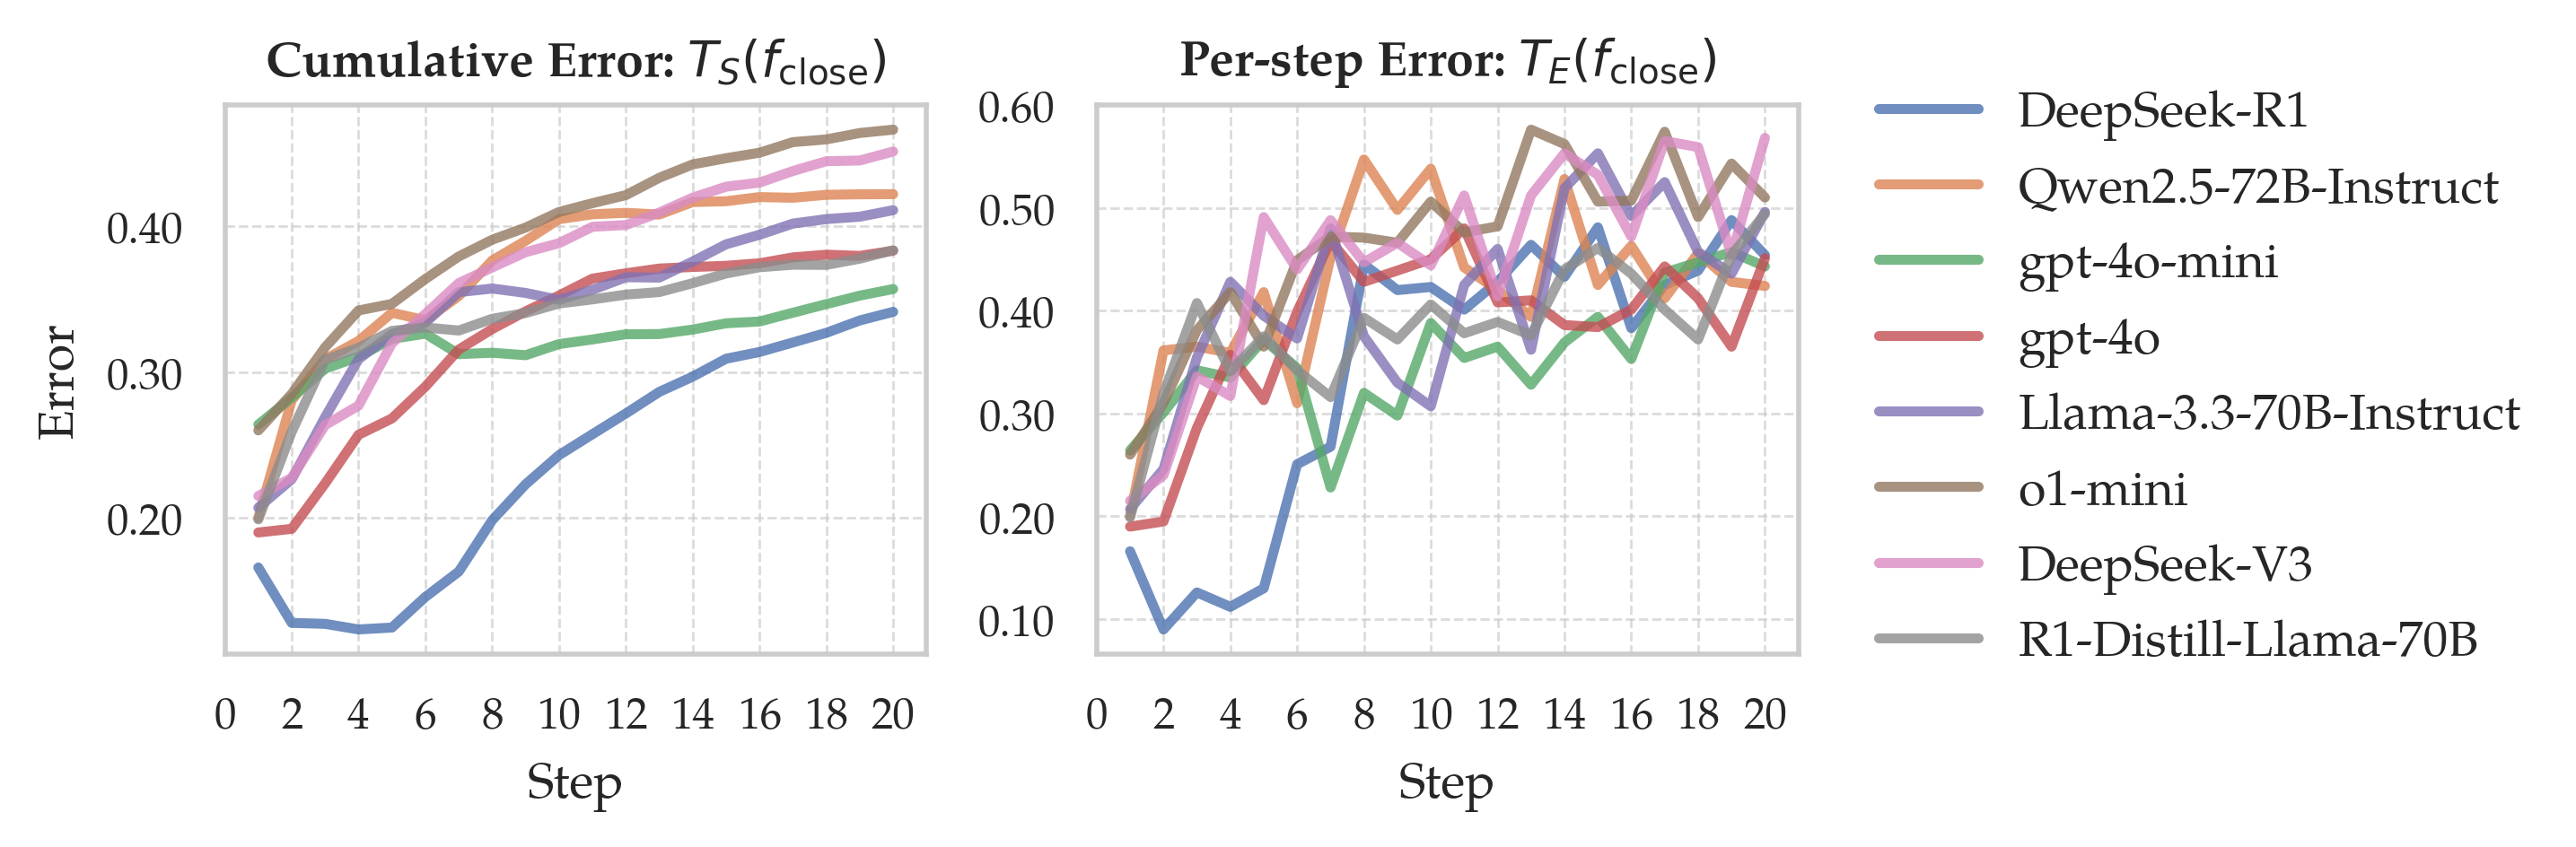

In [8]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import glob
import json
import numpy as np
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter


# Set Seaborn theme for a clean and publication-quality look.
sns.set_theme(style="whitegrid", context="paper", font="TeX Gyre Pagella")  # 'paper' context optimizes font sizes

data_path = 'res_same_topic/*/acc_list.txt'
data_files = glob.glob(data_path)

# Define colors for multiple plots
colors = sns.color_palette("deep", len(data_files))
marker_options = ['o', 'v', 's', '*', 'D', 'P', 'X', 'p']

fig2 = plt.figure(2, figsize=(5, 2.3), dpi=400)
gs2 = gridspec.GridSpec(1, 2, width_ratios=[1, 1])  # Last column is wider
        
axes2 = [fig2.add_subplot(gs2[0]), fig2.add_subplot(gs2[1])]

for idx, data_f in enumerate(data_files):
    with open(data_f, 'r') as f:
        model_name = data_f.split('/')[-2].split('_')[0]
        if model_name == 'DeepSeek-R1-Distill-Llama-70B':
            model_name = r'R1-Distill-Llama-70B'
        acc_list = np.array(json.loads(f.readlines()[0]))

        # Always ensure the last 20 values are considered (or fewer if not available)
        acc_list = 1 - acc_list[-20:]
        iterations = np.arange(1, len(acc_list) + 1)  # Ensure integer x-axis values

        cum_list = np.cumsum(acc_list)
        cum_list = cum_list / np.arange(1, 21)
    
    axes2[1].plot(iterations, acc_list, linestyle='-', linewidth=2,
                  alpha=0.8, color=colors[idx], label=model_name)
    
    axes2[0].plot(iterations, cum_list, linestyle='-', linewidth=2,
                  color=colors[idx], alpha=0.8, label=model_name)

# X-axis fix: Force range from 1 to 20
for i in range(2):
    axes2[i].set_xticks(np.arange(0, 21, 2))
    axes2[i].set_xlim(0, 21)
    axes2[i].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    axes2[i].set_xlabel(r'Step', fontsize=10)

    # Grid and title
    axes2[i].grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
fig2.tight_layout()

axes2[1].set_title(r'Per-step Error: $T_E(f_{\text{close}})$', fontsize=10, fontweight='bold')
axes2[0].set_title(r'Cumulative Error: $T_S(f_{\text{close}})$', fontsize=10, fontweight='bold')
axes2[0].set_ylabel(r'Error', fontsize=10)
axes2[1].legend(fontsize=10, loc='center left', bbox_to_anchor=(1.05, 0.5), frameon=False)


# Save as a single figure
fig2.savefig("paper_figs/step_acc_topic_combined_2.pdf", format="pdf", bbox_inches='tight')
fig2.show()


20000
20000
20000
20000


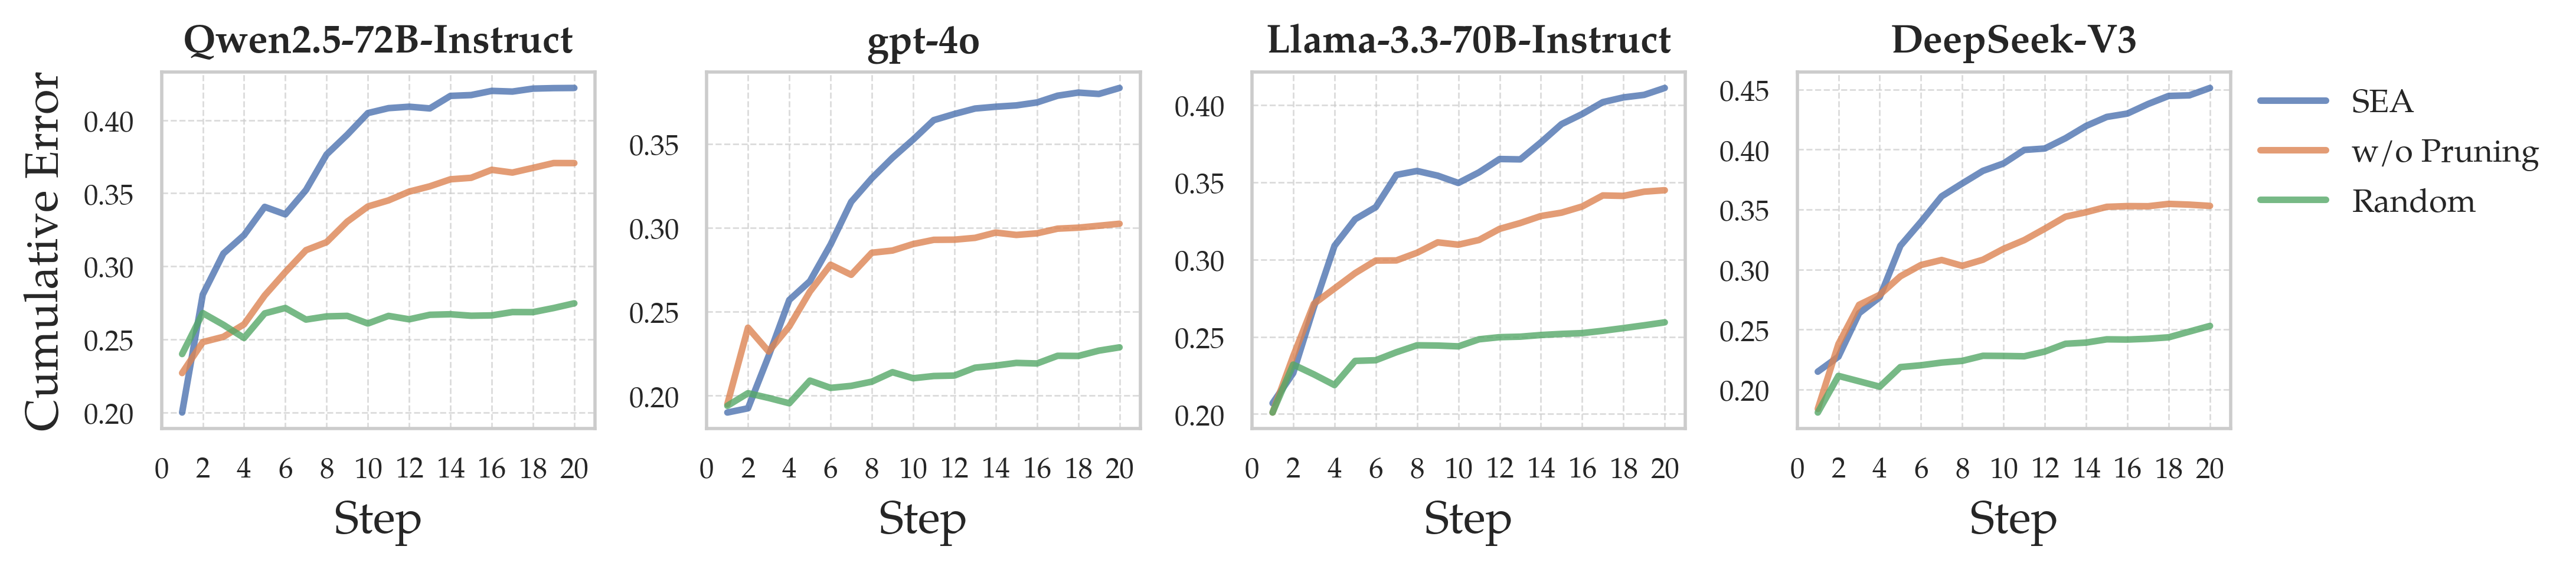

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import glob
import json
import numpy as np
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter


def process_exist(data: dict):
    corr_list = []
    for page, pvalue in data.items():
        for pc, pcvalue in pvalue.items():
            if pc in ["id", "abstract"]:
                continue
            corr = 0
            for qa in pcvalue['qa']:
                if qa.get('llm_answer', None) is None:
                    continue
                is_correct = 0 if qa['is_correct'] == False else 1
                corr += is_correct
                corr_list.append(is_correct)
    print(len(corr_list))
    acc_list = np.array(corr_list).reshape(20, 1000).mean(axis=1)
    return acc_list

# Set Seaborn theme for a clean and publication-quality look.
sns.set_theme(style="whitegrid", context="paper", font="TeX Gyre Pagella")  # 'paper' context optimizes font sizes

model_list = [
    "Llama-3.3-70B-Instruct",
    "DeepSeek-V3",
    "Qwen2.5-72B-Instruct",
    "gpt-4o",
]
data_path = 'res_same_topic/*/acc_list.txt'
data_files = glob.glob(data_path)

# Define colors for multiple plots
colors = sns.color_palette("deep", len(data_files))
marker_options = ['o']

# Create figure and GridSpec
fig = plt.figure(figsize=(11, 2.5), dpi=400)
gs = gridspec.GridSpec(1, 4)  # Last column is wider

axes = []
for j in range(4):
    ax = fig.add_subplot(gs[0, j])
    axes.append(ax)

idx = 0
for data_f in data_files:
    with open(data_f, 'r') as f:
        model_name = data_f.split('/')[-2].split('_')[0]
        if model_name not in model_list:
            continue
        if model_name == 'DeepSeek-R1-Distill-Llama-70B':
            model_name = r'R1-Distill-Llama-70B'
        acc_list = np.array(json.loads(f.readlines()[0]))
    
    abla_path = data_f.replace('res_same_topic', 'res_same_topic_abla').replace('_cumacc', '_avgacc')
    with open(abla_path, 'r') as f:
        abla_list = np.array(json.loads(f.readlines()[0]))
        
    rand_path = glob.glob(f'res_random/{model_name}*/ans.json')[0]
    with open(rand_path, 'r') as f:
        rand_res = json.load(f)
        rand_list = process_exist(rand_res)

    # Always ensure the last 20 values are considered (or fewer if not available)
    acc_list = 1 - acc_list[-20:]
    acc_cum_list = np.cumsum(acc_list)
    acc_cum_list = acc_cum_list / np.arange(1, 21)
    
    abla_list = 1 - abla_list[-20:]
    abla_cum_list = np.cumsum(abla_list)
    abla_cum_list = abla_cum_list / np.arange(1, 21)
    
    rand_list = 1 - rand_list
    rand_cum_list = np.cumsum(rand_list)
    rand_cum_list = rand_cum_list / np.arange(1, 21)
    
    iterations = np.arange(1, len(acc_list) + 1)  # Ensure integer x-axis values
    
    ax = axes[idx]
    # Plot each model with a unique color
    ax.plot(iterations, acc_cum_list, linestyle='-', linewidth=2,
            color=colors[0], alpha=0.8, label=r'SEA')
    ax.plot(iterations, abla_cum_list, linestyle='-', linewidth=2,
            color=colors[1], alpha=0.8, label=r'w/o Pruning')
    ax.plot(iterations, rand_cum_list, linestyle='-', linewidth=2,
            color=colors[2], alpha=0.8, label=r'Random')

    # Labels
    if idx // 4 == 0:
        ax.set_xlabel(r'Step', fontsize=14)
    if idx in [0, 4]:
        ax.set_ylabel(r'Cumulative Error', fontsize=14)

    # X-axis fix: Force range from 1 to 20
    ax.set_xticks(np.arange(0, 21, 2))
    ax.set_xlim(0, 21)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    # Grid and title
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    ax.set_title(model_name, fontsize=12, fontweight='bold')
    
    if idx == 3:
        ax.legend(bbox_to_anchor=(1, 0.5), fontsize=10, loc='lower left', frameon=False)
    idx += 1
    
# Adjust layout to prevent overlap
plt.tight_layout()

# Save as a single figure
plt.savefig("paper_figs/abla.pdf", format="pdf")
plt.show()

# Distribution Visulization

In [ ]:
# Topics from LDA
# topics = [
#     "Baseball",
#     "American Football",
#     "Metro/Railway/Transportation Projects",
#     "Swimming and Paralympic/Olympic Sports",
#     "Music",
#     "Soccer / Association Football",
#     "Simple Time/Date/Day Mentions",
#     "College Football Polls & All‐American Lists",
#     "Coaching, Teams, and Seasons",
#     "Russian Localities and Districts"
# ]

In [1]:
from sentence_transformers import SentenceTransformer, util
import numpy as np
import glob
import json
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.cm as cm


def load_documents(file_path):
    """
    Load documents from a JSONL file.
    For 'paraset': use 'input' field and select records with avg_acc < 0.5.
    For 'qaset': use 'context' field and select records with label equal to 0.
    For other files: use 'context' field.
    """
    docs = []
    orig_docs = []
    models = []
    file_paths = glob.glob(file_path)
    for file in file_paths:
        with open(file, 'r', encoding='utf-8') as f:
            for line in f:
                data = json.loads(line)
                if "paraset" in file_path:
                    avg_acc = data.get("acc", 1.0)
                    if avg_acc > 0.5:
                        continue
                    doc = data.get("input", "")
                    orig_docs.append(data)
                elif "qaset" in file_path:
                    if data.get("label", 1) != 0:
                        continue
                    doc = data.get("question", "")
                if doc:
                    docs.append(doc)
                    models.append(file.split("/")[-1].split("_")[0])
    return docs, orig_docs, models


documents, orig_docs, document_models = load_documents("datasets_same_seed/*_paraset.jsonl")

# Wikipedia topics
# topics = [
#     "General reference",
#     "Culture and the arts",
#     "Geography and places",
#     "Health and fitness",
#     "History and events",
#     "Human activities",
#     "Mathematics and logic",
#     "Natural and physical sciences",
#     "People and self",
#     "Philosophy and thinking",
#     "Religion and belief systems",
#     "Society and social sciences",
#     "Technology and applied sciences"
# ]
topics = [
    "Baseball",
    "American Football",
    "Metro/Railway/Transportation Projects",
    "Swimming and Paralympic/Olympic Sports",
    "Music",
    "Soccer / Association Football",
    "Simple Time/Date/Day Mentions",
    "College Football Polls & All‐American Lists",
    "Coaching, Teams, and Seasons",
    "Russian Localities and Districts"
]

# Load the embedding model
embedder = SentenceTransformer('Alibaba-NLP/gte-multilingual-base', device='cuda:1', trust_remote_code=True)

# Get embeddings for documents and topics
doc_embeddings = embedder.encode(documents, convert_to_tensor=True)
topic_embeddings = embedder.encode(topics, convert_to_tensor=True)

# Calculate cosine similarity between each document and each topic
cosine_scores = util.cos_sim(doc_embeddings, topic_embeddings)

# Assign each document the topic with the highest similarity
assigned_topic_indices = np.argmax(cosine_scores.cpu().numpy(), axis=1)
assigned_topics = [topics[idx] for idx in assigned_topic_indices]

# Reduce dimensionality for visualization (using t-SNE or UMAP here)
tsne = TSNE(n_components=2, random_state=42)
# umap_model = umap.UMAP(n_components=2, random_state=42)
doc_embeddings_2d = tsne.fit_transform(doc_embeddings.cpu().numpy())

/linxindisk/miniconda3/envs/misinfo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at Alibaba-NLP/gte-multilingual-base were not used when initializing NewModel: {'classifier.bias', 'classifier.weight'}
- This IS expected if you are initializing NewModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing NewModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


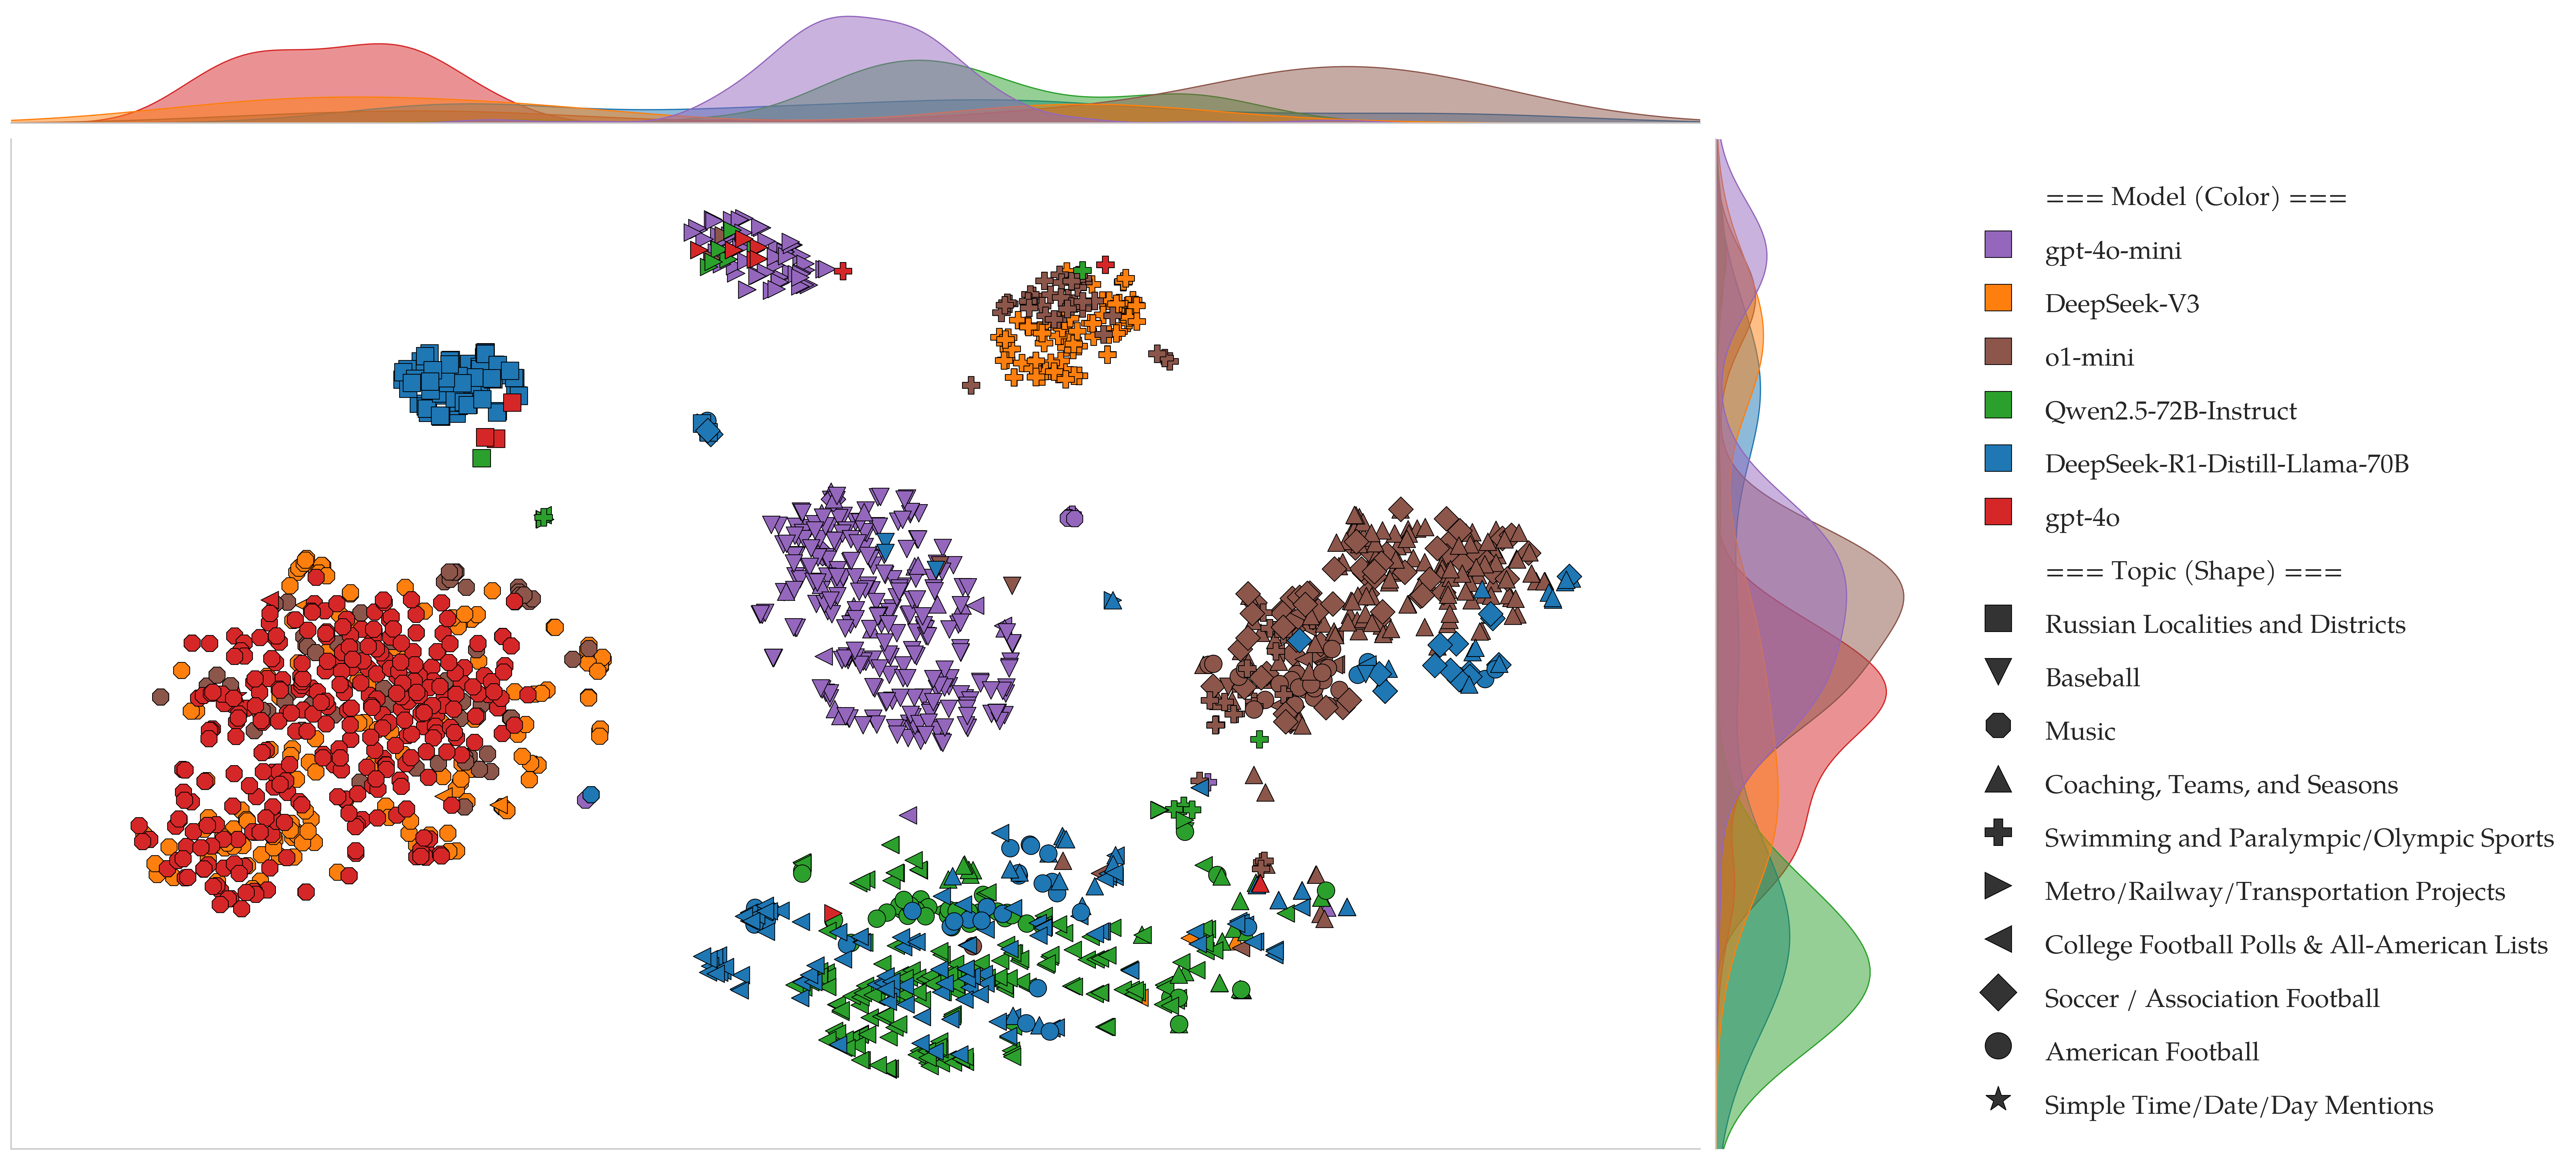

In [ ]:
import seaborn as sns
import pandas as pd

# Convert embeddings and models to a DataFrame
unique_topics = sorted(set(assigned_topics))
marker_options = ['o', 'v', '^', '<', '>', '8', 's', '*', 'D', 'P', 'X', 'd', 'p']  # extend if needed
topic_markers = {topic: marker_options[i % len(marker_options)] for i, topic in enumerate(unique_topics)}

unique_models = sorted(set(document_models))
colors = {model: cm.tab10(i) for i, model in enumerate(unique_models)}
sns.set_theme(style="whitegrid", context="paper", font="TeX Gyre Pagella")  # 'paper' context optimizes font sizes

df = pd.DataFrame({
    'x': doc_embeddings_2d[:, 0],
    'y': doc_embeddings_2d[:, 1],
    '=== Model (Color) ===': document_models,
    '=== Topic (Shape) ===': assigned_topics
})

topics = []
for i, (x, y) in enumerate(zip(df['x'], df['y'])):
    topics.append(topic_markers[assigned_topics[i]])

# **Create a joint grid with scatter + KDE contours**
g = sns.JointGrid(data=df, x="x", y="y", ratio=8)

# **Adjust the figure size AFTER creating JointGrid**
g.fig.set_size_inches(18, 11)
g.fig.set_dpi(400)

# **Plot scatter points on top (foreground)**
sns.scatterplot(data=df, 
                x="x", 
                y="y", 
                hue="=== Model (Color) ===", 
                style="=== Topic (Shape) ===", 
                palette=colors, 
                markers=topic_markers, 
                edgecolor='black', 
                s=130, 
                linewidth=0.5,
                ax=g.ax_joint, 
                zorder=2)

# **Plot KDE marginal distributions on x and y axes**
sns.kdeplot(data=df, x="x", hue="=== Model (Color) ===", palette=colors, ax=g.ax_marg_x, fill=True, alpha=0.5, legend=False)
sns.kdeplot(data=df, y="y", hue="=== Model (Color) ===", palette=colors, ax=g.ax_marg_y, fill=True, alpha=0.5, legend=False)

plt.tight_layout()

# **Plot formatting**
g.ax_joint.set_xticks([])
g.ax_joint.set_yticks([])
g.ax_joint.set_xlabel('')
g.ax_joint.set_ylabel('')
g.ax_joint.set_xlim(min(df['x']) - 10, max(df['x']) + 10)
g.ax_joint.set_ylim(min(df['y']) - 10, max(df['y']) + 10)
g.ax_joint.legend(loc="lower right", bbox_to_anchor=(1.52, 0), fontsize=17, frameon=False, handleheight=2, markerscale=1.5)

plt.savefig("paper_figs/model_topic_density_jointplot_large.pdf", format="pdf", bbox_inches='tight')
plt.show()

# Cross Validation

In [4]:
import networkx as nx

def directed_to_undirected_bi_edges(G):
    """ Convert a directed graph to an undirected graph by keeping only bidirectional edges. """
    H = nx.Graph()
    for u, v in G.edges():
        if G.has_edge(v, u):  # Only keep bidirectional edges
            H.add_edge(u, v)
    return H

def bron_kerbosch(R, P, X, cliques):
    """ Recursive Bron-Kerbosch algorithm to find all maximal cliques. """
    if not P and not X:
        cliques.append(R)
        return
    for v in list(P):
        bron_kerbosch(R | {v}, P & set(graph[v]), X & set(graph[v]), cliques)
        P.remove(v)
        X.add(v)

def find_max_bidirectional_clique(G):
    """ Find the largest bidirectional clique in a directed graph. """
    global graph  # Used inside Bron-Kerbosch
    U = directed_to_undirected_bi_edges(G)
    graph = {node: set(U.neighbors(node)) for node in U.nodes()}
    
    cliques = []
    bron_kerbosch(set(), set(U.nodes()), set(), cliques)
    
    # Return the largest clique
    return max(cliques, key=len) if cliques else []

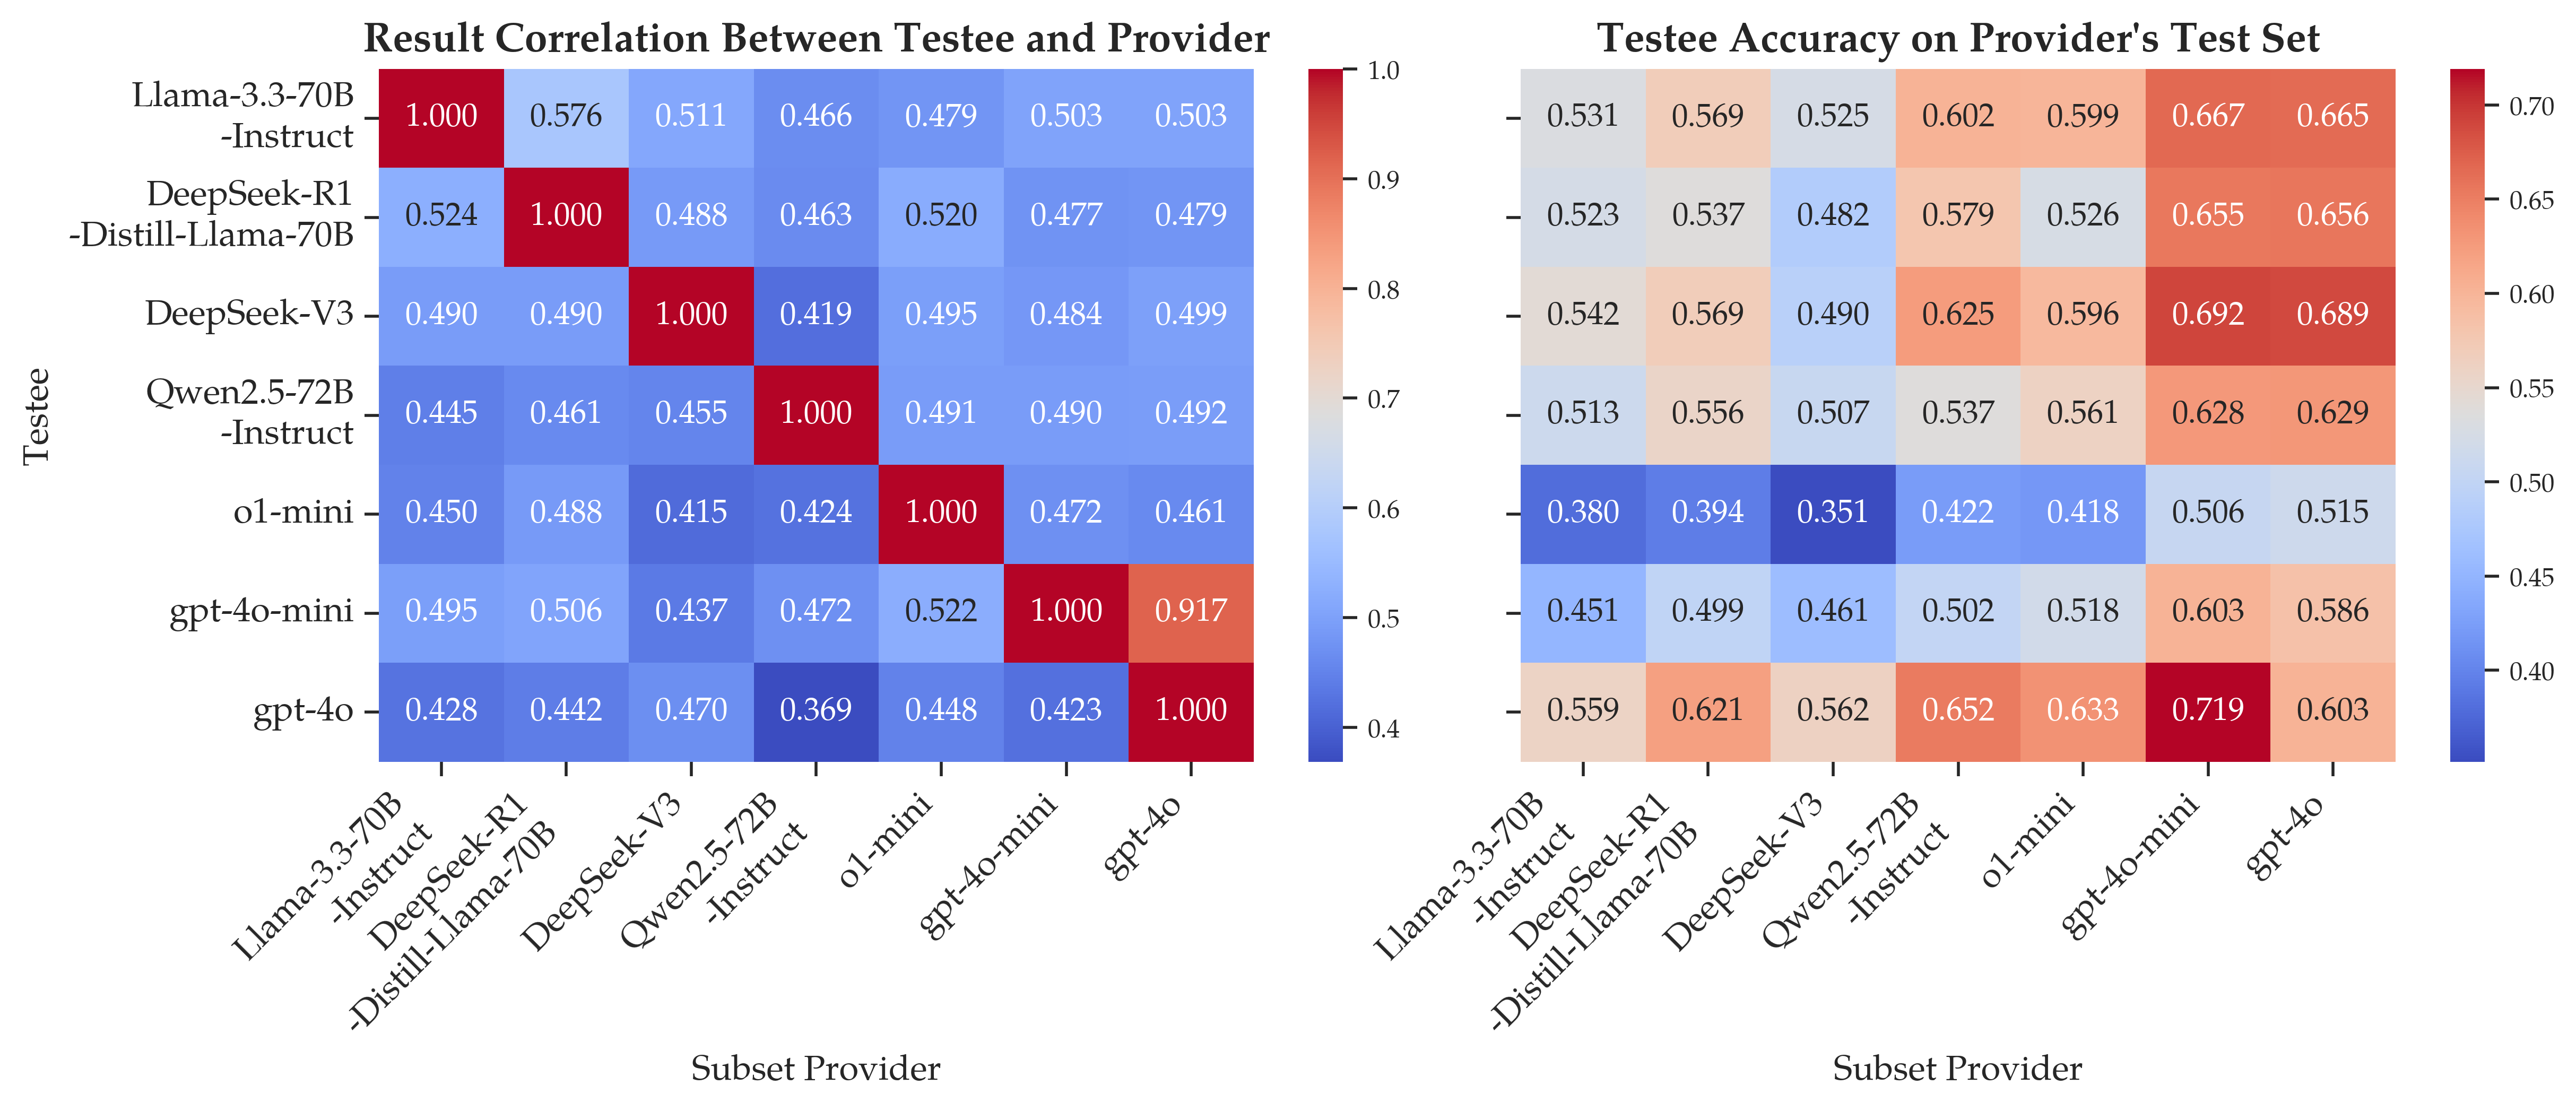

In [10]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

sns.set_theme(style="ticks", context="paper", font="TeX Gyre Pagella") 
def majority_voting(arr: np.array):
    arr = arr.reshape(-1, 5)
    sums = np.sum(arr, axis=1)
    return (sums >= 4).astype(int)


TESTEE_MODEL = [
    "Llama-3.3-70B-Instruct",
    "DeepSeek-R1-Distill-Llama-70B",  # llama 3.3 distilled
    "DeepSeek-V3",
    "Qwen2.5-72B-Instruct",
    "o1-mini",
    "gpt-4o-mini",
    "gpt-4o",
]

testee_list = list(TESTEE_MODEL)
ex_list = list(TESTEE_MODEL)
f1_res = np.zeros((len(testee_list), len(testee_list)))
acc_res = np.zeros((len(testee_list), len(testee_list)))
for i, testee in enumerate(testee_list):
    for j, ex in enumerate(testee_list):
        if testee == ex:
            continue
        dpath = f'res_same_topic/{testee}_exist_ex{ex}.json'
        with open(dpath, 'r') as f:
            data = json.load(f)
            testee_model_name = dpath.split("/")[-1].split("_")[0]
            ex_model_name = dpath.split("/")[-1].replace("_exist", "").split("_ex")[1].replace(".json", "")
            
            testee_res = majority_voting(np.array(data['testee']))
            ex_res = majority_voting(np.array(data['ex']))
            
            correlation, _ = pearsonr(testee_res, ex_res)
            
            pred_acc = np.sum(testee_res == 1) / len(testee_res)
            ex_acc = np.sum(ex_res == 1) / len(ex_res)
            
            ex_error_num = np.sum(ex_res == 0)
            
            TP = np.logical_and(testee_res == 1, ex_res == 1)
            TN = np.logical_and(testee_res == 0, ex_res == 0)
            FN = np.logical_and(testee_res == 1, ex_res == 0)
            FP = np.logical_and(testee_res == 0, ex_res == 1)
            
            # consider ex as ground truth, we can calculate the testee's accuracy and recall and f1
            accuracy = (np.sum(TP) + np.sum(TN)) / len(testee_res)
            recall = np.sum(TP) / (np.sum(TP) + np.sum(FN))
            precision = np.sum(TP) / (np.sum(TP) + np.sum(FP))
            f1 = 2 * precision * recall / (precision + recall)
            
            f1_res[i][j] = correlation
            f1_res[j][j] = 1
            
            acc_res[i][j] = pred_acc
            acc_res[j][j] = ex_acc

for tl in testee_list:
    if tl == 'DeepSeek-R1-Distill-Llama-70B':
        testee_list[testee_list.index(tl)] = 'DeepSeek-R1\n-Distill-Llama-70B'
    if tl == 'Llama-3.3-70B-Instruct':
        testee_list[testee_list.index(tl)] = 'Llama-3.3-70B\n-Instruct'
    if tl == 'Qwen2.5-72B-Instruct':
        testee_list[testee_list.index(tl)] = 'Qwen2.5-72B\n-Instruct'
        
f1df = pd.DataFrame(f1_res, index=testee_list, columns=testee_list)
accdf = pd.DataFrame(acc_res, index=testee_list, columns=testee_list)


# Create the heatmap with improved aesthetics
fig, axes = plt.subplots(1, 2, figsize=(12, 4.7), dpi=400, gridspec_kw={'width_ratios': [1, 1]})
# plt.figure(figsize=(6, 6), dpi=400)
sns.heatmap(f1df, 
            annot=True, 
            fmt=".3f", 
            cmap="coolwarm",
            # linewidths=1, 
            cbar=True, 
            # cbar_kws={'shrink': 0.95}, 
            square=False, 
            annot_kws={"size": 11},
            ax=axes[0])
plt.tight_layout()

# Improve axis labels
axes[0].set_xticklabels(testee_list, rotation=45, ha="right", fontsize=12)
axes[0].set_yticklabels(testee_list, fontsize=12)

# Improve title and axis labels
axes[0].set_xlabel("Subset Provider", fontsize=12)
axes[0].set_ylabel("Testee", fontsize=12)
axes[0].set_title('Result Correlation Between Testee and Provider', fontsize=14, fontweight='bold')

sns.heatmap(accdf, 
            annot=True, 
            fmt=".3f", 
            cmap="coolwarm",
            # linewidths=1, 
            cbar=True, 
            # cbar_kws={'shrink': 0.95}, 
            square=False, 
            annot_kws={"size": 11},
            ax=axes[1])
# Improve axis labels
axes[1].set_xticklabels(testee_list, rotation=45, ha="right", fontsize=12)
axes[1].set_yticklabels([], fontsize=0)

# Improve title and axis labels
axes[1].set_xlabel("Subset Provider", fontsize=12)
axes[1].set_title('Testee Accuracy on Provider\'s Test Set', fontsize=14, fontweight='bold')

# Save the figure with better resolution
plt.savefig("paper_figs/cross_validate_heatmap.pdf", format="pdf", bbox_inches="tight")

# Display the plot
plt.show()
plt.close()

In [2]:
f1df

Llama-3.3-70B\n-Instruct  \
Llama-3.3-70B\n-Instruct                         1.000000   
DeepSeek-R1\n-Distill-Llama-70B                  0.524204   
DeepSeek-V3                                      0.489915   
Qwen2.5-72B\n-Instruct                           0.444844   
o1-mini                                          0.450096   
gpt-4o-mini                                      0.495418   
gpt-4o                                           0.427946   

                                 DeepSeek-R1\n-Distill-Llama-70B  DeepSeek-V3  \
Llama-3.3-70B\n-Instruct                                0.576342     0.510748   
DeepSeek-R1\n-Distill-Llama-70B                         1.000000     0.488184   
DeepSeek-V3                                             0.490079     1.000000   
Qwen2.5-72B\n-Instruct                                  0.460556     0.454954   
o1-mini                                                 0.488078     0.415231   
gpt-4o-mini                                             0.506249     0.437339   
gpt-4o                                                  0.442093     0.469766   

                                 Qwen2.5-72B\n-Instruct   o1-mini  \
Llama-3.3-70B\n-Instruct                       0.466169  0.478663   
DeepSeek-R1\n-Distill-Llama-70B                0.462597  0.520293   
DeepSeek-V3                                    0.418990  0.495392   
Qwen2.5-72B\n-Instruct                         1.000000  0.490666   
o1-mini                                        0.424057  1.000000   
gpt-4o-mini                                    0.471950  0.521925   
gpt-4o                                         0.368864  0.447940   

                                 gpt-4o-mini    gpt-4o  
Llama-3.3-70B\n-Instruct            0.503017  0.502623  
DeepSeek-R1\n-Distill-Llama-70B     0.476802  0.479385  
DeepSeek-V3                         0.484234  0.498845  
Qwen2.5-72B\n-Instruct              0.489703  0.492177  
o1-mini                             0.471747  0.461465  
gpt-4o-mini                         1.000000  0.917029  
gpt-4o                              0.422535  1.000000

In [3]:
accdf

Llama-3.3-70B\n-Instruct  \
Llama-3.3-70B\n-Instruct                          0.53125   
DeepSeek-R1\n-Distill-Llama-70B                   0.52300   
DeepSeek-V3                                       0.54250   
Qwen2.5-72B\n-Instruct                            0.51350   
o1-mini                                           0.37975   
gpt-4o-mini                                       0.45125   
gpt-4o                                            0.55900   

                                 DeepSeek-R1\n-Distill-Llama-70B  DeepSeek-V3  \
Llama-3.3-70B\n-Instruct                                0.568672      0.52475   
DeepSeek-R1\n-Distill-Llama-70B                         0.536842      0.48250   
DeepSeek-V3                                             0.568672      0.48975   
Qwen2.5-72B\n-Instruct                                  0.555890      0.50750   
o1-mini                                                 0.394236      0.35150   
gpt-4o-mini                                             0.499248      0.46050   
gpt-4o                                                  0.621053      0.56200   

                                 Qwen2.5-72B\n-Instruct  o1-mini  gpt-4o-mini  \
Llama-3.3-70B\n-Instruct                       0.601772  0.59900     0.667427   
DeepSeek-R1\n-Distill-Llama-70B                0.578987  0.52625     0.654753   
DeepSeek-V3                                    0.624810  0.59550     0.691762   
Qwen2.5-72B\n-Instruct                         0.537468  0.56100     0.628137   
o1-mini                                        0.422278  0.41825     0.505957   
gpt-4o-mini                                    0.501772  0.51850     0.602535   
gpt-4o                                         0.652405  0.63300     0.719138   

                                   gpt-4o  
Llama-3.3-70B\n-Instruct         0.665146  
DeepSeek-R1\n-Distill-Llama-70B  0.656020  
DeepSeek-V3                      0.688720  
Qwen2.5-72B\n-Instruct           0.629404  
o1-mini                          0.514829  
gpt-4o-mini                      0.585551  
gpt-4o                           0.602535